In [50]:
using JuMP
using MadNLP
using ProgressMeter
using CairoMakie
import Plots.plot as pplot
import Plots.plot! as pplot!

Classical Lennard-Jones potential (see also https://en.wikipedia.org/wiki/Lennard-Jones_potential):
$$
    W_{x, x'}(r) := 4 \left[
        \left(\frac{|x - x'|}{r}\right)^{12}
        - \left(\frac{|x - x'|}{r}\right)^6
    \right].
$$

The optimization algorithm experiences too large numbers for the above potential.
In order to overcome this we use a slightly different Lennard-Jones type potential:
$$
    W_{x, x'}(r) := 4 \left[
        \left(\frac{|x - x'|}{r}\right)^{\color{magenta}4}
        - \left(\frac{|x - x'|}{r}\right)^{\color{magenta}2}
    \right].
$$

In [51]:
# Lennard-jones of squared distances instead of distances
function lennard_jones(cur_dist_sq; pref_dist=1, pot_min=-1)
    # the factor 2 assures that the global
    # minimum is attained at cur_dist == pref_dist
    q = pref_dist^2/(2*cur_dist_sq)
    -4*pot_min*(q^2 - q)
end

lennard_jones (generic function with 1 method)

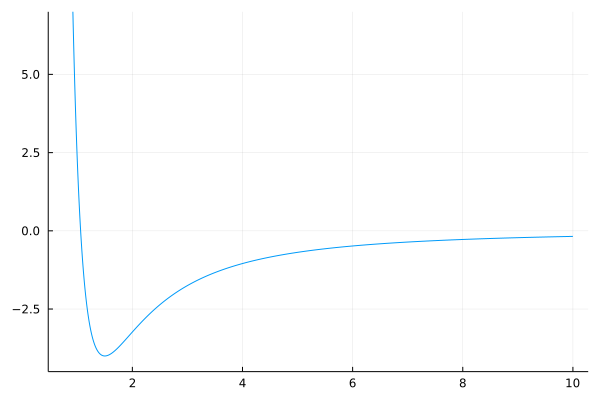

In [52]:
pot_min = -4
pref_dist = 1.5
xs = range(pref_dist/2, 10, length=1000)
f(r) = lennard_jones(r, pref_dist=pref_dist, pot_min=pot_min)
ys = f.(xs.^2)
pplot(xs, ys, ylims=(pot_min-0.5, 7), label=nothing)

In [53]:
N = 20
max_stretch = 0.25
time_stretch = 2
time_pause = 0.25
time_horizon = time_stretch + time_pause
fps = 120
pref_dist = 1/(N-1)
break_dist = 2* pref_dist
pot_min = -1.
elastic_thresh = 2*pref_dist
search_rad = 1.
diss_coeff = 1.
alpha = 100
eps = pref_dist/10
animation_width = 800
hidpi_scaling = 4
file_name = "crack_evol"
two_sided_pull = true
fontsize = 16
only_video = true

true

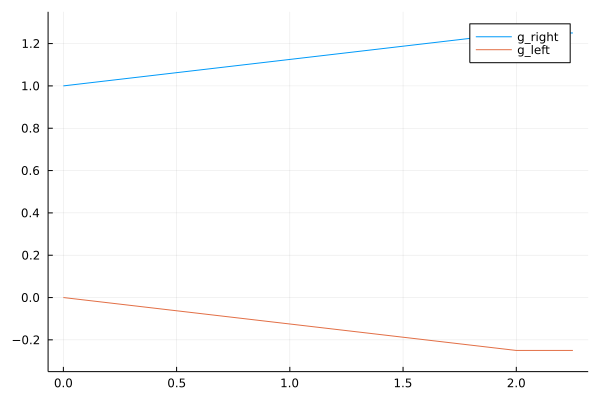

In [54]:
function dirichlet_delta(t; max_stretch=1, time_stretch=1, time_pause=1.5)
    # max_stretch*sin(2*pi/time_horizon*t)
    if t <= time_stretch
        return max_stretch*t/time_stretch
    else
        return max_stretch
    end
end
g_right(t) = 1 + dirichlet_delta(t; max_stretch=max_stretch, time_stretch=time_stretch, time_pause=time_pause)
if two_sided_pull
    g_left(t) = -dirichlet_delta(t; max_stretch=max_stretch, time_stretch=time_stretch, time_pause=time_pause)
else
    g_left(t) = 0
end
xs = range(0, time_horizon, length=1000)
ys = g_right.(xs)
ymin = two_sided_pull ? -max_stretch : 0
pplot(xs, g_right.(xs), ylims=(ymin -.1, 1 + max_stretch + .1), label="g_right")
pplot!(xs, g_left.(xs), ylims=(ymin -.1, 1 + max_stretch + .1), label="g_left")

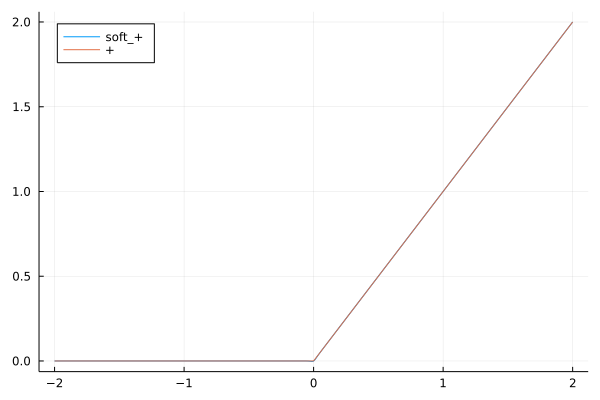

In [55]:
soft_max(x, y) = (x*exp(alpha*x) + y*exp(alpha*y)) / 
    (exp(alpha*x) + exp(alpha*y))
xs = range(-2., 2., length=1000)
soft_ys = [soft_max(x, 0.) for x in xs]
ys = [max(x, 0.) for x in xs]
pplot(xs, soft_ys, label="soft_+", legend=:topleft)
pplot!(xs, ys, label="+")

In [56]:
step = 2
minmove_l2 = Model(
    optimizer_with_attributes(
        MadNLP.Optimizer,
        "print_level" => MadNLP.WARN,
        "blas_num_threads" => 4
    )
)

# TODO: use macros instead (not super important)
@NLparameter(minmove_l2, prev_y[i=1:N] == (i-1)/(N-1))
@NLparameter(minmove_l2, max_elong_sq[i=1:N-1] == 1/(N-1)^2)

@variable(
    minmove_l2,
    value(prev_y[i]) - search_rad <= y[i=1:N] <= value(prev_y[i]) + search_rad,
    start=value(prev_y[i])
)

# Dirichlet condition on the right endpoint
# TODO: do not keep y[1] and y[N] as optimization variables 
# as their value is predetermined.
@constraint(
    minmove_l2, dirichlet_right,
    y[N] == g_right((step-1)/fps)
)
@constraint(
    minmove_l2, dirichlet_left,
    y[1] == g_left((step-1)/fps)
)

# Regularization (maybe not even needed):
# distance between neighboring atoms cannot
# go below a certain value
@constraint(
    minmove_l2, min_dist[i=1:N-1],
    y[i+1] - y[i] >= eps
)

# Define the energy
@expression(minmove_l2, dist_sq[i=1:N-1], (y[i+1] - y[i])^2)
# Explicitely write out the softmax
# FIXME: softmax needs to be ONLY applied if max_elong_sq[i] > break_distance
@NLexpression(
    minmove_l2, damaged_dist_sq[i=1:N-1],
    (dist_sq[i]*exp(alpha*dist_sq[i]) + max_elong_sq[i]*exp(alpha*max_elong_sq[i])) /
        (exp(alpha*dist_sq[i]) + exp(alpha*max_elong_sq[i]))
)
W(d) = lennard_jones(d, pref_dist=pref_dist, pot_min=pot_min)
register(minmove_l2, :W, 1, W, autodiff = true)
@NLexpression(
    minmove_l2, energy, 
    .5/(N-1)*sum(W(damaged_dist_sq[i]) for i in 1:N-1)
)

# dissipation
@NLexpression(
    minmove_l2, dissipation,
    .5/N*sum((y[i] - prev_y[i])^2 for i in 2:N-1)
)
@NLobjective(minmove_l2, Min, energy + diss_coeff*fps*dissipation)

minmove_l2

A JuMP Model
Minimization problem with:
Variables: 20
Objective function type: Nonlinear
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 2 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 19 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 20 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 20 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: MadNLP
Names registered in the model: damaged_dist_sq, dirichlet_left, dirichlet_right, dissipation, dist_sq, energy, max_elong_sq, min_dist, prev_y, y

In [57]:
optimize!(minmove_l2)

In [58]:
function get_energy(y)
    N = length(y)
    0.5/(N-1)*sum(W.((y[2:end]-y[1:end-1]).^2))
end
abs(get_energy(value.(y)) - value(energy))

1.634445482129321e-5

In [59]:
function get_dissipation(y, prev_y)
    N = length(y)
    0.5/N*sum((y - prev_y).^2)
end
abs(get_dissipation(value.(y), value.(prev_y)) - value(dissipation))

5.425347222221914e-8

In [60]:
function get_total(y, prev_y, fps, diss_coeff)
    get_energy(y) + fps*diss_coeff*get_dissipation(y, prev_y)
end
abs(get_total(value.(y), value.(prev_y), fps, diss_coeff) - objective_value(minmove_l2))

2.2854871487953954e-5

In [61]:
get_total(value.(y), value.(prev_y), fps, diss_coeff)

-0.499968383238437

In [62]:
minmoves = [value.(prev_y), value.(y)];

In [63]:
@showprogress "Computing minmoves..." for step in 3:fps*time_horizon
    # update maximal elongation
    yval = value.(y)
    comp_max_elong_sq = (yval[2:end] - yval[1:end-1]).^2
    new_max_elong_sq = max(value.(max_elong_sq), comp_max_elong_sq)
    set_value.(max_elong_sq, new_max_elong_sq)
    
    set_value.(prev_y, value.(y))
    
    set_normalized_rhs(dirichlet_right, g_right((step-1)/fps))
    set_normalized_rhs(dirichlet_left, g_left((step-1)/fps))
    
    optimize!(minmove_l2)
    
    push!(minmoves, value.(y))
end

Computing minmoves... 100%|██████████████████████████████| Time: 0:00:00


In [64]:
function animate_steps(minmoves, file_name; fps=30, width=600, fontsize=11, scale=1, save_snapshots=false)
    experiments_folder = "experiments"
    if !ispath(experiments_folder)
        mkdir(experiments_folder)
    end
    if save_snapshots
        snapshots_folder = "$experiments_folder/$file_name"
        if !ispath(snapshots_folder)
            mkdir(snapshots_folder)
        end
    end
    
    aspect = 4
    ax_aspect = 4
    height = width/aspect
    max_right = maximum([y[end] for y in minmoves])
    min_left = minimum([y[1] for y in minmoves])
    delta = 0.1
    max_len = max_right - min_left + 2delta
    ax_height = max_len/ax_aspect
    N = length(minmoves[1])
    
    fig = Figure(resolution=(scale*width, scale*height), fontsize=scale*fontsize)
    ax = Axis(
        fig[1, 1],
        limits=(min_left-delta, max_right+delta, -ax_height/2, ax_height/2),
        aspect=ax_aspect,
    )
    
    y = zeros(N)
    
    frame = 1
    record(fig, "experiments/$file_name.mp4", minmoves; framerate = fps) do (x)
        empty!(ax)
        scatter!(x, y, color=:blue, markersize=scale*6)
        if save_snapshots
            save("$snapshots_folder/$(file_name)_$frame.pdf", fig)
        end
        frame += 1
    end
end

animate_steps (generic function with 1 method)

In [65]:
animate_steps(
    minmoves, file_name, 
    fps=60, 
    width=animation_width, 
    fontsize=fontsize,
    scale=hidpi_scaling,
    save_snapshots=!only_video
)

"experiments/crack_evol.mp4"